# Example CV3 - Function fitting with a quantum neural network

In this example we show how a variational circuit can be used to learn a fit for a one-dimensional function when being trained with noisy samples from that function. 

The variational circuit we use is the continuous-variable quantum neural network model described in [Killoran et al. (2018)](https://arxiv.org/abs/1806.06871). 

### Imports

We import PennyLane, the wrapped version of NumPy provided by PennyLane, and an optimizer. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

The device we use is the Strawberry Fields simulator, this time with only one quantum mode (or `wire`). You will need to have the Strawberry Fields plugin for PennyLane installed.

In [2]:
try:
    dev = qml.device('strawberryfields.fock', wires=1, cutoff_dim=10)    
except:
    print("To run this demo you need to install the strawberryfields plugin...")

### Quantum node

For a single quantum mode, each layer of the variational circuit is defined as:

In [3]:
def layer(v):

    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0., wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0., wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into the displacement of the mode, and then executes the layers. The output is the expectation of the x-quadrature.

In [4]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    
    # Encode input x into quantum state
    qml.Displacement(x, 0., wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval.X(0)

### Objective

As an objective we take the square loss between target labels and model predictions.

In [5]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    loss = loss / len(labels)

    return loss

In the cost function, we compute the outputs from the variational circuit. Function fitting is a regression problem, and we interpret the expectations from the quantum node as predictions (i.e., without applying postprocessing such as thresholding).

In [6]:
def cost(var, features, labels):

    preds = [quantum_neural_net(var, x=x) for x in features]

    return square_loss(labels, preds)

### Optimization

We load noisy data samples of a sine function.

In [7]:
data = np.loadtxt("data/sine.txt")
X = data[:, 0]
Y = data[:, 1]

Before training a model, let's examine the data.

*Note: For the next cell to work you need the matplotlib library.* 

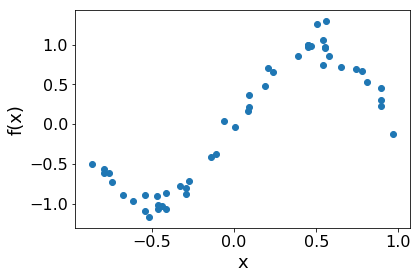

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.scatter(X, Y)
plt.xlabel('x', fontsize=18)
plt.ylabel('f(x)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

The network's weights (called `var` here) are initialized with values sampled from a normal distribution. We use 4 layers; performance has been found to plateau at around 6 layers.

In [9]:
num_layers = 4
np.random.seed(5)
var_init = 0.05 * np.random.randn(num_layers, 7)

var_init

array([[ 0.02206137, -0.01654351,  0.12153856, -0.01260461,  0.00548049,
         0.07912406, -0.04546162],
       [-0.02958183,  0.00938016, -0.0164935 , -0.05963823, -0.01024383,
        -0.01794145,  0.03017358],
       [-0.08323943, -0.03500895,  0.05756955,  0.09286655, -0.07555898,
         0.03224238, -0.04903039],
       [-0.04284266, -0.04359396, -0.0211254 ,  0.04982199,  0.03562106,
         0.00295721, -0.01816554]])

Using the Adam optimizer, we update the weights for 10 steps.

In [10]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(10):
    var = opt.step(lambda v: cost(v, X, Y), var)
    
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it+1, cost(var, X, Y)))

Iter:     1 | Cost: 0.4903563 
Iter:     2 | Cost: 0.4617620 
Iter:     3 | Cost: 0.4367777 
Iter:     4 | Cost: 0.4135471 
Iter:     5 | Cost: 0.3911694 
Iter:     6 | Cost: 0.3691356 
Iter:     7 | Cost: 0.3471503 
Iter:     8 | Cost: 0.3250655 
Iter:     9 | Cost: 0.3028538 
Iter:    10 | Cost: 0.2806003 


We can continue training up to 100 total steps (this takes some time). To get a good result, up to 500 steps are necessary.

In [11]:
for it in range(100):
    var = opt.step(lambda v: cost(v, X, Y), var)
    
    print("Iter: {:5d} | Cost: {:0.7f}".format(it+1, cost(var, X, Y)))

Iter:     1 | Cost: 0.2584973
Iter:     2 | Cost: 0.2368399
Iter:     3 | Cost: 0.2160133
Iter:     4 | Cost: 0.1964712
Iter:     5 | Cost: 0.1787017
Iter:     6 | Cost: 0.1631813
Iter:     7 | Cost: 0.1503201
Iter:     8 | Cost: 0.1404050
Iter:     9 | Cost: 0.1335495
Iter:    10 | Cost: 0.1296610
Iter:    11 | Cost: 0.1284334
Iter:    12 | Cost: 0.1293713
Iter:    13 | Cost: 0.1318416
Iter:    14 | Cost: 0.1351466
Iter:    15 | Cost: 0.1386043
Iter:    16 | Cost: 0.1416223
Iter:    17 | Cost: 0.1437538
Iter:    18 | Cost: 0.1447285
Iter:    19 | Cost: 0.1444577
Iter:    20 | Cost: 0.1430154
Iter:    21 | Cost: 0.1406029
Iter:    22 | Cost: 0.1375035
Iter:    23 | Cost: 0.1340352
Iter:    24 | Cost: 0.1305066
Iter:    25 | Cost: 0.1271833
Iter:    26 | Cost: 0.1242640
Iter:    27 | Cost: 0.1218703
Iter:    28 | Cost: 0.1200475
Iter:    29 | Cost: 0.1187744
Iter:    30 | Cost: 0.1179784
Iter:    31 | Cost: 0.1175543
Iter:    32 | Cost: 0.1173812
Iter:    33 | Cost: 0.1173387
Iter:    3

Finally, we collect the predictions of the trained model for 50 values in the range $[-1,1]$...

In [12]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

...and plot the shape of the function that the model has "learned" from the noisy data (green dots).

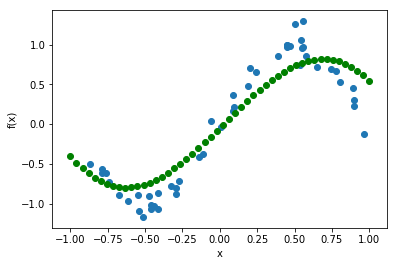

In [13]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color='green')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()

The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the model produces without being trained at all. The shape of these functions varies significantly with the variance hyperparameter for the weight initialization. 

Setting this hyperparameter to a small value produces almost linear functions, since all quantum gates in the variational circuit approximately perform the identity transformation in that case. Larger values produce smoothly oscillating functions with a period that depends on the number of layers used (generically, the more layers, the smaller the period).

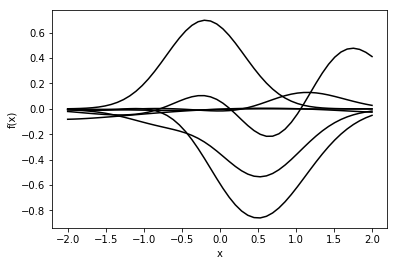

In [14]:
variance = 1.

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color='black')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()